In [19]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [26]:
#os.environ[api_key]=(os.getenv('GROQ_API_KEY'))

In [29]:
from groq import Groq
import textwrap
import os
from dotenv import load_dotenv


load_dotenv()

client = Groq(api_key=os.getenv("GROQ_API_KEY"))

In [28]:
pip install langchain openai pandas python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install -U langchain-anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [langchain-anthropic]thropic]
Note: you may need to restart the kernel to use updated packages.


In [4]:
from typing import List, Dict, Optional
import pandas as pd
import os
import json
from dataclasses import dataclass

# LangChain imports 
#from langchain.chat_models import ChatOpenAI
#from langchain.tools import Tool
#from langchain.agents import initialize_agent, AgentType

Create a sales agent, make a dummy csv file for product, it contains product ID product description, 

create a filter tool and give top 5 recommendation upon prompt with product ID

filter on product type, minimum rating and price range


tool to check inventory returns Boolean
tool for checkout


example prompt: hey I am looking to buy a smart phone

model should probe for features if information is insufficient.{recurring}

example output: based on your requirements here are the top 5 products:

user: I would like to proceed with xyz product, add it to the cart

model runs the inventory check tool and if product exist add to cart and return the product_ID

Data Creation : 

In [6]:
CSV_PATH = "products_dummy.csv"


if not os.path.exists(CSV_PATH):
    products = [
    {"product_id": "P1001", "name": "FlashPhone X1", "description": "smartphone with 6.5-inch OLED, 128GB, 48MP camera", "product_type": "smartphone", "price": 499.0, "rating": 4.5, "inventory": 10},
    {"product_id": "P1002", "name": "BudgetCall 5", "description": "affordable smartphone, 64GB, 13MP camera", "product_type": "smartphone", "price": 149.0, "rating": 3.8, "inventory": 25},
    {"product_id": "P1003", "name": "LuxPhone Ultra", "description": "flagship smartphone, 256GB, 108MP camera, wireless charging", "product_type": "smartphone", "price": 999.0, "rating": 4.8, "inventory": 3},
    {"product_id": "P2001", "name": "SoundMax Headphones", "description": "over-ear noise-cancelling headphones", "product_type": "headphones", "price": 199.0, "rating": 4.3, "inventory": 15},
    {"product_id": "P3001", "name": "Speedy Charger 30W", "description": "usb-c fast charger", "product_type": "accessory", "price": 29.0, "rating": 4.0, "inventory": 50},
    {"product_id": "P1004", "name": "MidRange Z", "description": "smartphone with balanced features, 128GB, 64MP camera", "product_type": "smartphone", "price": 349.0, "rating": 4.2, "inventory": 0},
    ]
    df = pd.DataFrame(products)
    df.to_csv(CSV_PATH, index=False)
else:
    df = pd.read_csv(CSV_PATH)

In [1]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model


model = init_chat_model(
    "anthropic:claude-sonnet-4-5",
    temperature=0
)


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

In [12]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

Define model node:

In [13]:
from langchain.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

Define tool node

In [14]:
from langchain.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

Define end logic

In [16]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

Build and compile the agent

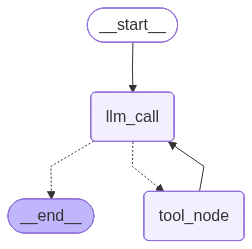

TypeError: "Could not resolve authentication method. Expected either api_key or auth_token to be set. Or for one of the `X-Api-Key` or `Authorization` headers to be explicitly omitted"

In [27]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()